In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
    
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c jane-street-market-prediction
!unzip '/content/train.csv.zip'
!unzip '/content/example_test.csv.zip'

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 66.3MB/s]
  0% 0.00/59.0 [00:00<?, ?B/s]
100% 59.0/59.0 [00:00<00:00, 170kB/s]
  0% 0.00/23.3k [00:00<?, ?B/s]
100% 23.3k/23.3k [00:00<00:00, 22.9MB/s]
  0% 0.00/16.4M [00:00<?, ?B/s]
100% 16.4M/16.4M [00:00<00:00, 151MB/s]
100% 2.60G/2.61G [00:25<00:00, 53.8MB/s]
100% 2.61G/2.61G [00:25<00:00, 111MB/s] 
  0% 0.00/108k [00:00<?, ?B/s]
100% 108k/108k [00:00<00:00, 120MB/s]
Archive:  /content/train.csv.zip
  inflating: train.csv               
Archive:  /content/example_test.csv.zip
  inflating: example_test.csv        


In [ ]:
sub = pd.read_csv(r'/content/example_sample_submission.csv')
sub.head(2)

,ts_id,action
0,0,1
1,1,1


In [ ]:
feat = pd.read_csv(r'/content/features.csv')
print(feat.shape)
feat.head(2)

(130, 30)


,feature,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28
0,feature_0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,feature_1,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
tst = pd.read_csv(r'/content/example_test.csv')
print(tst.shape)
tst.head(2)

(15219, 133)


,weight,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,...,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,date,ts_id
0,0.000000,1,-1.872746,-2.191242,-0.474163,-0.323046,0.014688,-0.002484,NaN,NaN,-0.989982,-1.055090,NaN,NaN,-2.667671,-2.001475,-1.703595,-2.196892,NaN,NaN,1.483295,1.307466,NaN,NaN,1.175200,0.967805,1.60841,1.319365,NaN,NaN,-0.515073,-0.448988,NaN,NaN,-2.429812,-2.206423,-3.593120,-2.868358,0.112697,0.053157,...,NaN,3.754522,7.137163,-1.863069,NaN,0.434466,NaN,-0.292035,0.317003,-2.605820,NaN,2.896986,NaN,1.485813,4.147254,-2.238831,NaN,-0.892724,NaN,-0.156332,0.622816,-3.921523,NaN,2.561593,NaN,3.457757,6.649580,-1.472686,NaN,NaN,1.168391,8.313583,1.782433,14.018213,2.653056,12.600292,2.301488,11.445807,0,0
1,16.673515,-1,-1.349537,-1.704709,0.068058,0.028432,0.193794,0.138212,NaN,NaN,-0.151877,-0.384952,NaN,NaN,1.225838,0.789076,1.110580,1.102281,NaN,NaN,-0.590600,-0.625682,NaN,NaN,-0.543425,-0.547486,-0.70660,-0.667806,NaN,NaN,0.910558,0.914465,NaN,NaN,2.137454,2.080459,2.819291,2.483965,-0.086755,-0.082687,...,NaN,1.297679,1.281956,-2.427595,NaN,0.024913,NaN,-0.413607,-0.073672,-2.434546,NaN,0.949879,NaN,0.724655,1.622137,-2.209020,NaN,-1.332492,NaN,-0.586619,-1.040491,-3.946097,NaN,0.983440,NaN,1.357907,1.612348,-1.664544,NaN,NaN,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684,0,1


In [ ]:
pip install datatable

     |████████████████████████████████| 83.7MB 51kB/s 


In [ ]:
import datatable as dt
train_data_datatable = dt.fread('/content/train.csv')
trn = train_data_datatable.to_pandas()
print(trn.info())
# Delete unnecessary variable in order to free more space from RAM
del train_data_datatable
trn.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float64(135), int32(3)
memory usage: 2.4 GB
None


,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,0,0.000000,0.009916,0.014079,0.008773,0.001390,0.006270,1,-1.872746,-2.191242,-0.474163,-0.323046,0.014688,-0.002484,NaN,NaN,-0.989982,-1.055090,NaN,NaN,-2.667671,-2.001475,-1.703595,-2.196892,NaN,NaN,1.483295,1.307466,NaN,NaN,1.175200,0.967805,1.60841,1.319365,NaN,NaN,-0.515073,-0.448988,NaN,NaN,...,1.158770,NaN,3.754522,7.137163,-1.863069,NaN,0.434466,NaN,-0.292035,0.317003,-2.605820,NaN,2.896986,NaN,1.485813,4.147254,-2.238831,NaN,-0.892724,NaN,-0.156332,0.622816,-3.921523,NaN,2.561593,NaN,3.457757,6.649580,-1.472686,NaN,NaN,1.168391,8.313583,1.782433,14.018213,2.653056,12.600292,2.301488,11.445807,0
1,0,16.673515,-0.002828,-0.003226,-0.007319,-0.011114,-0.009792,-1,-1.349537,-1.704709,0.068058,0.028432,0.193794,0.138212,NaN,NaN,-0.151877,-0.384952,NaN,NaN,1.225838,0.789076,1.110580,1.102281,NaN,NaN,-0.590600,-0.625682,NaN,NaN,-0.543425,-0.547486,-0.70660,-0.667806,NaN,NaN,0.910558,0.914465,NaN,NaN,...,1.157671,NaN,1.297679,1.281956,-2.427595,NaN,0.024913,NaN,-0.413607,-0.073672,-2.434546,NaN,0.949879,NaN,0.724655,1.622137,-2.209020,NaN,-1.332492,NaN,-0.586619,-1.040491,-3.946097,NaN,0.983440,NaN,1.357907,1.612348,-1.664544,NaN,NaN,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684,1


# Calculate the utility index as a column

In [ ]:
trn['action'] = np.where( trn['resp']  > 0, 1, 0)

In [ ]:
dfnull = pd.DataFrame ( trn.isnull().sum() [ trn.isnull().sum()>11123900 ] ).index
listOfAll = [f for f in trn.columns if 'feature' in f] 
listOfValid = list ( set(listOfAll) - set(dfnull) )

In [ ]:
X_train = trn  #[ listOfValid ]
y_train = trn['action'].values
del trn

In [ ]:
# X_train = X_train.drop(['feature_0'],1)
# listOfValid = set( listOfValid ) - set( ['feature_0'])

## Write a transformer to get only the columns

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def select_columns( X ): # pandas dataframe
    return X[listOfValid]

In [ ]:
pipe = Pipeline( [('select_columns', FunctionTransformer(select_columns) )                 
                 , ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)  )
                 , ('scaler', StandardScaler() )]
               )



In [ ]:
X_train = pipe.fit_transform(X_train)

In [ ]:
# pip install mlxtend

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(verbose=0 , n_estimators=9 , max_depth=9 )

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

sfs1 = SFS(clf, 
           k_features= 5, 
           forward =True, 
           floating=False, 
           verbose=2,
           scoring='precision',
           cv=0, n_jobs=-1)


sfs1 = sfs1.fit(X_train, y_train)


# This dictionary contains results from all compuations
metricDict = sfs1.get_metric_dict()

print( metricDict)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed: 87.2min finished

[2021-02-20 05:24:18] Features: 1/5 -- score: 0.5171198213734953[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed: 74.0min finished

[2021-02-20 06:38:17] Features: 2/5 -- score: 0.5281141896330734[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed: 65.4min finished

[2021-02-20 07:43:42] Features: 3/5 -- score: 0.5343043335270161[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 32.1min
[Parallel(n_jobs=-1)]: Done 127 out of 1

{1: {'feature_idx': (86,), 'cv_scores': array([0.51711982]), 'avg_score': 0.5171198213734953, 'feature_names': ('86',), 'ci_bound': nan, 'std_dev': 0.0, 'std_err': nan}, 2: {'feature_idx': (9, 86), 'cv_scores': array([0.52811419]), 'avg_score': 0.5281141896330734, 'feature_names': ('9', '86'), 'ci_bound': nan, 'std_dev': 0.0, 'std_err': nan}, 3: {'feature_idx': (9, 27, 86), 'cv_scores': array([0.53430433]), 'avg_score': 0.5343043335270161, 'feature_names': ('9', '27', '86'), 'ci_bound': nan, 'std_dev': 0.0, 'std_err': nan}, 4: {'feature_idx': (9, 14, 27, 86), 'cv_scores': array([0.54067668]), 'avg_score': 0.5406766761998507, 'feature_names': ('9', '14', '27', '86'), 'ci_bound': nan, 'std_dev': 0.0, 'std_err': nan}, 5: {'feature_idx': (9, 14, 27, 86, 98), 'cv_scores': array([0.54418812]), 'avg_score': 0.544188123635445, 'feature_names': ('9', '14', '27', '86', '98'), 'ci_bound': nan, 'std_dev': 0.0, 'std_err': nan}}


[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed: 94.0min finished

[2021-02-20 11:04:58] Features: 5/5 -- score: 0.544188123635445/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:

# This dictionary contains results from all compuations
metricDict = sfs1.get_metric_dict()

print( metricDict)


{1: {'feature_idx': (86,), 'cv_scores': array([0.51711982]), 'avg_score': 0.5171198213734953, 'feature_names': ('86',), 'ci_bound': nan, 'std_dev': 0.0, 'std_err': nan}, 2: {'feature_idx': (9, 86), 'cv_scores': array([0.52811419]), 'avg_score': 0.5281141896330734, 'feature_names': ('9', '86'), 'ci_bound': nan, 'std_dev': 0.0, 'std_err': nan}, 3: {'feature_idx': (9, 27, 86), 'cv_scores': array([0.53430433]), 'avg_score': 0.5343043335270161, 'feature_names': ('9', '27', '86'), 'ci_bound': nan, 'std_dev': 0.0, 'std_err': nan}, 4: {'feature_idx': (9, 14, 27, 86), 'cv_scores': array([0.54067668]), 'avg_score': 0.5406766761998507, 'feature_names': ('9', '14', '27', '86'), 'ci_bound': nan, 'std_dev': 0.0, 'std_err': nan}, 5: {'feature_idx': (9, 14, 27, 86, 98), 'cv_scores': array([0.54418812]), 'avg_score': 0.544188123635445, 'feature_names': ('9', '14', '27', '86', '98'), 'ci_bound': nan, 'std_dev': 0.0, 'std_err': nan}}


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


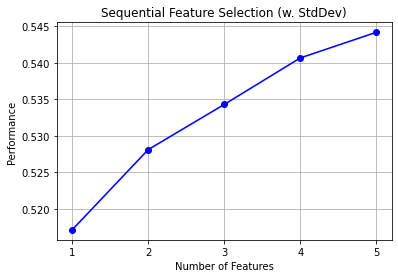

['feature_43', 'feature_61', 'feature_42', 'feature_20', 'feature_63']


In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs  
import matplotlib.pyplot as plt
# =============================================================================
# Plot performance of features
# =============================================================================

# Initialise plot
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')

#plt.ylim([0.8, 1])
plt.title('Sequential Feature Selection (w. StdDev)')
plt.grid()
plt.show()

# =============================================================================
# Access indices and names of best features
# =============================================================================




In [ ]:
# Get indices of best features
k_ind = (0, 45, 50, 72, 129) # sfs1.k_feature_idx_

# Get names of best features using numpy arrays
feature_names = listOfValid
bestFeatures_names = [feature_names[i] for i in k_ind]
print( bestFeatures_names)

['feature_76', 'feature_21', 'feature_59', 'feature_16', 'feature_85']


In [ ]:
clf = RandomForestClassifier(verbose=0 , n_estimators=99 , max_depth=17 )
clf.fit(X_train[:, [9, 14, 27, 86, 98]] ,
        y_train)

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_train, y_train)  
plt.show()

NotFittedError: ignored